This script applies KF to the measurement data. There is a provision to apply estimate filtering to reject spurrious estimates. This filtering using either innovation covariance or mixture model of the sensor. 

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 13 15:17:51 2017

@author: Nishant
"""
import math
import csv
import numpy as np
import matplotlib.pyplot as plt

# Calculates stats for given data
def stats(reads):
    mu=sum(reads)/len(reads)
    sq=[x*x for x in reads]
    sig=sum(sq)/len(sq)-mu*mu
    return mu,sig

# Returns value of Gaussian pdf of mixture for a passed measurement xs 
def sample_from_gaussian(pdf,x):
    pow=-1/2*(x-pdf[0])*(x-pdf[0])/(pdf[1])
    return (1/np.sqrt(2*math.pi*pdf[1]))*np.exp(pow)

# Returns value of exp decay pdf of mixture for a passed measurement xs
def sample_exp_decay(xs):
    return 0.05*np.exp(-0.05*xs)

# Declaration of some global lists
x_measures=[]
x_measurescm=[]
x_estimates=[]
v_estimates=[]
sigx=[]
sigv=[]
sigxv=[]
T=[0]

# Returns a list corresponding to proportion of xi belonging to different components in the mixture
def get_mixture_probs(xp,xs):
    return [0.8*sample_from_gaussian([xp[0][0],0.001],xs),0.2*sample_exp_decay(xs)]

In [6]:
# Takes in system Markov model i.e. A,P,R,q, Current measurement xs, Prior xm 
# Outputs updated state estimate and updated uncertainty
def KF(xm,xs,P,R,A,q,n,td):

    b=np.array([[+(td**3)*0.01*(0.1**3)-(0.1**3)*0.01*(0.1**3), (td**2)*0.01*(0.1**2)-(0.1**2)*0.01*(0.1**2)],[(td**2)*0.01*(0.1**2)-(0.1**2)*0.01*(0.1**2),(td)*0.01*(0.1)-(0.1)*0.01*(0.1)]])
    c=np.array([[0,(td-1)*0.1],[0,0]])

    A=np.array(A)-np.array(c)
    q=np.array(q)+np.array(b)

    x_predicted=A*xm
    Pn=np.dot(A,P*np.transpose(A))+q
    H=np.asmatrix([1,0])

    a=np.dot(H,(Pn*np.transpose(H))+R)
    K=Pn*np.transpose(H)/a
    #K=np.reshape(np.array([K[0][0],K[1][0]]),(2,1))

    if n==1:
        x_posterior=x_predicted+K*(xs-H*x_predicted)
        P_posterior=(np.identity(2)-K*H)*Pn

        T.append(T[-1]+0.1)
    elif n==2:
        x_temp=x_predicted+K*(xs-H*x_predicted)
        P_temp=(np.identity(2)-K*H)*Pn
        delta=xs-float(x_temp[0])
        inno=np.dot(H,(P_temp*np.transpose(H)))
        var=delta*delta/inno
        if var<9:
            x_posterior=x_predicted+K*(xs-H*x_predicted)
            P_posterior=(np.identity(2)-K*H)*Pn
            T.append(T[-1]+0.1*td)
            td=1

        else:
            td+=1
            return np.array([]),np.array([]),td

    elif n==3:
        x_temp=x_predicted+K*(xs-H*x_predicted)
        p=get_mixture_probs(x_temp,xs)

        if p[0]>p[1]:
            x_posterior=np.array(x_predicted)+np.array(K)*(xs-np.dot(H,x_predicted))
            P_posterior=(np.identity(2)-K*H)*Pn
            T.append(T[-1]+0.1*td)
            td=1
        else:
            td+=1
            return np.array([]),np.array([]),td

    return x_posterior,P_posterior,td


In [7]:
# Iterates through measurement data, updates posteriors using KF and stores it to a list
def estimate(n):
    P0=np.array([[0.01, 0],[0, 0.01]])
    x0=np.asmatrix([25.30,.1]).T
    R=0.001
    Q=[[0.01*0.1*0.1*0.1, 0.01*0.1*0.1],[0.01*0.1*0.1,0.01*0.1]]
    A=[[1,-0.1],[0,1]]
    t=1
    
    for i in x_measures:
        xm=i
        xt,Pt,t=KF(x0,xm,P0,R,A,Q,n,t)
        if xt.tolist()!=[] and Pt.tolist()!=[]:
            x_estimates.append(float(xt[0])*100)
            v_estimates.append(float(xt[1])*100)
            sigx.append(np.sqrt(Pt.tolist()[0][0]*10000))
            sigv.append(np.sqrt(Pt.tolist()[1][1]*10000))
            sigxv.append(Pt.tolist()[0][1]*10000/np.sqrt(Pt.tolist()[0][0]*10000)/np.sqrt(Pt.tolist()[1][1]*10000))
            x0=np.asmatrix(xt)
            P0=np.asmatrix(Pt)

## KF with innovation covariance based rejection

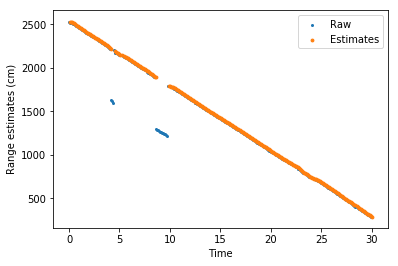

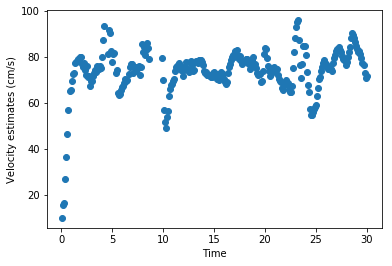

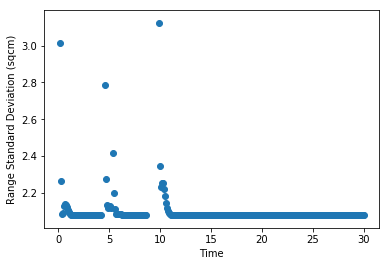

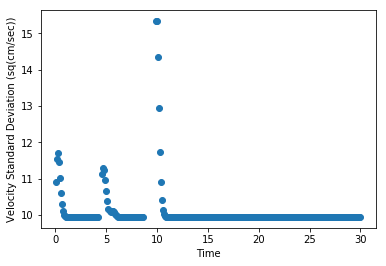

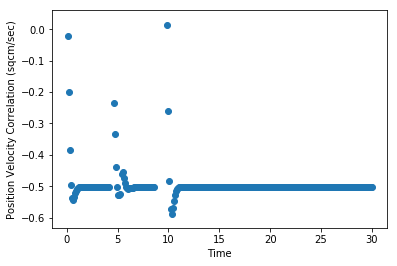

In [8]:
#Script starts from here
#Reading data file and queuing data
with open('RBE500-F17-100ms-Constant-Vel.csv', newline='') as csvfile:
 spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
 spamreader=list(spamreader)
 for row in spamreader:
    x_measures.append(float(row[0])/100)
    x_measurescm.append(float(row[0]))
    
# Input the following numbers as arguments to estimate() for the corresponding postprocessing/filtering of KF estimates
# 1: Conventional KF   2: KF with object rejection (innovation)  3: KF with object rejection (mixture model)
estimate(2)


# Plot data
T.remove(0)
Ta=np.arange(0.0, 30.0, 0.1)

plt.scatter(Ta,x_measurescm,s=4,label='Raw')
plt.scatter(T,x_estimates,s=8,label='Estimates')
plt.xlabel('Time')
plt.legend()
plt.ylabel('Range estimates (cm)')
plt.show()

plt.scatter(T,v_estimates)
plt.xlabel('Time')
plt.ylabel('Velocity estimates (cm/s)')
plt.show()

plt.scatter(T,sigx)
plt.xlabel('Time')
plt.ylabel('Range Standard Deviation (sqcm)')
plt.show()

plt.scatter(T,sigv)
plt.xlabel('Time')
plt.ylabel('Velocity Standard Deviation (sq(cm/sec))')
plt.show()

plt.scatter(T,sigxv)
plt.xlabel('Time')
plt.ylabel('Position Velocity Correlation (sqcm/sec)')
plt.show()

Interpretation: The object rejection works by trading off precision for accuracy of the estimate. As seen in the plots the range estimate has gaps in areas of high uncertainty. This type of rejection also maintains a good estimate of velocity. Hence a bit of extra processing of estimates can improve the estimate accuracy. 